<a href="https://colab.research.google.com/github/anton-brandl/sam-bridges/blob/main/notebooks/20230609_training_data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetune SAM
##  Creating training and eval data
The used data is stored in input_data and was produced by the previous notebook.

In this notebook, I want to get modify SAM in a way that I can finetune it.
Then, after loading sample training data, I want to kick off a finetuning job.

In [1]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 45.5 MB/s eta 0:00:00


### Step 1: Load Satellite imagery and mask and validate (same dimensions)
We also tesselate the tiles by using a windowed data loading

In [6]:
import rasterio
from rasterio.windows import Window
import math
import pandas as pd

TILE_SIZE=256

dataset_dicts = []

# TODO: Extract duplicated code into function

# Open the existing GeoTIFF file
with rasterio.open("drive/MyDrive/sam_bridges/munich_satellite_z16.tif") as fp:
  dims = fp.shape
  num_rows = math.ceil(fp.shape[0]/TILE_SIZE)
  num_cols = math.ceil(fp.shape[1]/TILE_SIZE)
  for row_off in range(num_rows):
    for col_off in range(num_cols):
      # windowed reading of the sub-tile
      w = fp.read(None, window=Window(col_off*TILE_SIZE, row_off*TILE_SIZE, TILE_SIZE, TILE_SIZE))
      w = w.transpose(1,2,0)  # CHW to HWC ordering

      dataset_dicts.append({
          'tile_id': col_off+num_cols*row_off,
          'col_off': col_off,
          'row_off': row_off,
          'type': 'sat',
          'data': w})

with rasterio.open("drive/MyDrive/sam_bridges/munich_bridge_masks_z16.tif") as fp:
  assert dims == fp.shape, "Shapes don't match up"
  num_rows = math.ceil(fp.shape[0]/TILE_SIZE)
  num_cols = math.ceil(fp.shape[1]/TILE_SIZE)
  for row_off in range(num_rows):
    for col_off in range(num_cols):
      # windowed reading of the sub-tile
      w = fp.read(1, window=Window(col_off*TILE_SIZE, row_off*TILE_SIZE, TILE_SIZE, TILE_SIZE))
      dataset_dicts.append({
          'tile_id': col_off+num_cols*row_off,
          'col_off': col_off,
          'row_off': row_off,
          'type': 'mask',
          'data': w})

dataset = pd.DataFrame(dataset_dicts)
assert len(dataset[dataset.type=='mask']) == len(dataset[dataset.type=='sat'])

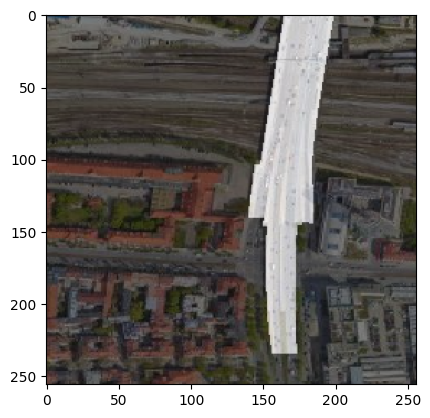

In [22]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

# Visual check of a sample tile
sample_data_point = dataset[dataset.tile_id == 26]
sample_sat = sample_data_point.query('type=="sat"').iloc[0].data
sample_bridge = sample_data_point.query('type=="mask"').iloc[0].data
plt.imshow((0.5*sample_sat + 0.5*np.stack(3*[sample_bridge*255], axis=-1)).astype(np.uint8))

### Step 2: Assign tiles to train and test datasets


In [8]:
dataset_size = dataset.tile_id.nunique()
train_size = math.floor(dataset_size*0.8)  # use an 80/20 split

dataset['split'] = 'test'
dataset.loc[dataset.tile_id<train_size, 'split'] = 'train'

### Step 3: A function that creates a sample prompt based on the mask
For each mask tile, we select only one foreground object, then create a new mask, sample foreground and background points, and a (non-centered) bounding box around the mask. For now, we don't train on text prompts, but later the category can be used for training on text prompts

In [52]:
import cv2
import random
import logging

logger = logging.getLogger()
def mask_to_prompts(mask, max_bbox_dilation_px = 20):
  # Get bounding boxes for each object in the mask
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  bboxes = []
  all_foreground_points = []
  all_background_points = []

  # Foreach bounding box:
  for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    # Increase bounds of bounding box randomly
    dilation_vals = [random.randint(0, max_bbox_dilation_px) for _ in range(4)]
    x_new = x-dilation_vals[0]
    y_new = y-dilation_vals[1]
    w_new = w+dilation_vals[0]+dilation_vals[2]
    h_new = h+dilation_vals[1]+dilation_vals[3]

    # Sample random points within the bounding box and classify them as foreground or background
    for attempt in range(30):
      foreground_points = []
      background_points = []
      for i in range(10):
        rand_x = random.randint(x_new, x_new+w_new)
        rand_y = random.randint(y_new, y_new+h_new)

        dist = cv2.pointPolygonTest(contour,(rand_x, rand_y), False)
        # dist is +1 if point is inside contour, -1 if outside, 0 if on the contour
        if dist>=0:  # point on or inside contour
          foreground_points.append((rand_x, rand_y))
        else:
          background_points.append((rand_x, rand_y))
      if len(foreground_points)>0:
        break

    if len(foreground_points)==0:
      logger.warn("Didn't find a suitable foreground point!")
    # Append prompts to list of prompts
    all_foreground_points.extend(foreground_points)
    all_background_points.extend(background_points)
    bboxes.append((x_new, y_new, w_new, h_new))

  # Return the dilated bounding boxes, with sample points for all objects
  return bboxes, all_foreground_points, all_background_points

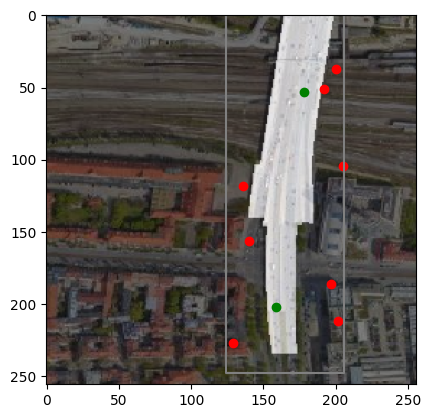

In [53]:
# Control visualization

bboxes, foreground_points, background_points = mask_to_prompts(sample_bridge)
plt.imshow((0.5*sample_sat + 0.5*np.stack(3*[sample_bridge*255], axis=-1)).astype(np.uint8))

# Plot Foreground points in green
for point_x, point_y in foreground_points:
  plt.plot(point_x, point_y, marker='o', color="green")

# Plot Background points in red
for point_x, point_y in background_points:
  plt.plot(point_x, point_y, marker='o', color="red")

# Plot enlarged bounding box in gray
for bbox_x, bbox_y, bbox_w, bbox_h in bboxes:
  plt.plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='gray')

### Step 4: Create Train and test folders

In [55]:
import os

dataset_folder = 'drive/MyDrive/sam-bridges/dataset'
train_folder = os.path.join(dataset_folder, 'train')
test_folder = os.path.join(dataset_folder, 'test')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

for tile_id, df in dataset.groupby('tile_id'):
  assert len(df) == 2, "Currently only supported for exactly one mask per satellite tile"
  split = df.split.iloc[0]
  mask = df[df['type']=='mask'].data.iloc[0]
  bboxes, foreground_points, background_points = mask_to_prompts(mask)
  datapoint_folder = os.path.join(dataset_folder, split, str(tile_id))
  os.makedirs(datapoint_folder, exist_ok=True)
  np.save(os.path.join(datapoint_folder, 'bboxes.npy'), np.array(bboxes))
  np.save(os.path.join(datapoint_folder, 'fg_points.npy'), np.array(foreground_points))
  np.save(os.path.join(datapoint_folder, 'bg_points.npy'), np.array(background_points))
  np.save(os.path.join(datapoint_folder, 'mask.npy'), mask)